### CONFIGURATION

In [12]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
from cellpose import models, io
from glob import glob
import config

# --- CONFIGURATION ---
# 1. Path to your 4x images
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")

CACHE_PATH = os.path.join(config.DATASPACE, "cellpose_cache")
os.makedirs(CACHE_PATH, exist_ok=True)
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = CACHE_PATH

# 2. Now import cellpose (It will see the variable and use the new path)
from cellpose import models, io

print(f"Cellpose will save models to: {os.environ['CELLPOSE_LOCAL_MODELS_PATH']}")

# 2. Pick a Core to test (Change "Core_01" to any core you want to check)
TEST_CORE = "Core_10" 
CK_INDEX = 6  # The Cytokeratin channel index

# 3. TUNING PARAMETERS (The knobs you want to turn)
# 'cyto2' is usually best for cytoplasm/tissue sheets. 
# 'nuclei' is for nuclei.
MODEL_TYPE = 'nuclei' 

DIAMETER = 20
# 3. LOWER FLOW THRESHOLD (The "Messy" Permitter)
# 0.4 is standard. 0.8 allows for "weird" non-circular shapes.
# Since a web is VERY weird, we max this out.
FLOW_THRESHOLD = 0.9

# 4. NEGATIVE CELL PROBABILITY (The "Sensitivity" Booster)
# Default is 0.0. Setting to -1.0 or -2.0 forces it to keep faint signals.
CELLPROB_THRESHOLD = -2.0 

# 5. REMOVE MIN SIZE
# Don't let it delete small bits of the web.
MIN_SIZE = 10

Cellpose will save models to: /data3/junming/3D-TMA-Register/cellpose_cache


### 1. Load the Image

Loading: /data3/junming/3D-TMA-Register/downsampled_4x/Core_10/240919_3D_BL_TMA_1_Core10.ome.tif
Image Shape: (1512, 1512)
Data Type: uint16 (Max Value: 735)


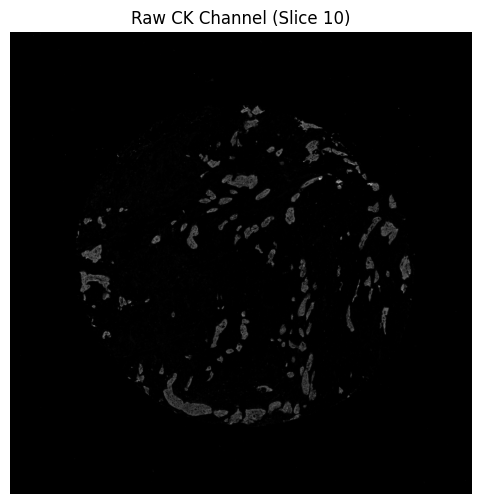

In [13]:
# Find the middle slice of the test core
core_folder = os.path.join(INPUT_ROOT, TEST_CORE)
slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))

if not slice_files:
    print(f"Error: No images found in {core_folder}")
else:
    # Pick middle slice
    mid_idx = len(slice_files) // 2
    test_file = slice_files[mid_idx]
    print(f"Loading: {test_file}")

    # Load
    img = tifffile.imread(test_file)
    
    # Extract CK Channel
    if img.shape[0] < 20: 
        ck = img[CK_INDEX, :, :]
    else: 
        ck = img[:, :, CK_INDEX]
    
    print(f"Image Shape: {ck.shape}")
    print(f"Data Type: {ck.dtype} (Max Value: {ck.max()})")

    # Normalize for display
    ck_vis = cv2.normalize(ck, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(ck_vis, cmap='gray')
    plt.title(f"Raw CK Channel (Slice {mid_idx})")
    plt.axis('off')
    plt.show()

### 2. Run Cellpose Inference

In [14]:
print(f"Initializing Cellpose model: {MODEL_TYPE}...")
# Use CellposeModel directly
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

print(f"Running Inference (Diameter={DIAMETER})...")

# FIX: Unpack only 3 values (masks, flows, styles)
masks, flows, styles = model.eval(
    ck, 
    diameter=DIAMETER, 
    channels=[0,0], # Grayscale
    flow_threshold=FLOW_THRESHOLD,
    cellprob_threshold=CELLPROB_THRESHOLD,
    min_size=MIN_SIZE
)

print(f"Done. Found {len(np.unique(masks)) - 1} regions.")

model_type argument is not used in v4.0.1+. Ignoring this argument...


Initializing Cellpose model: nuclei...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Running Inference (Diameter=20)...
Done. Found 627 regions.


### 3. Visualize Prediction

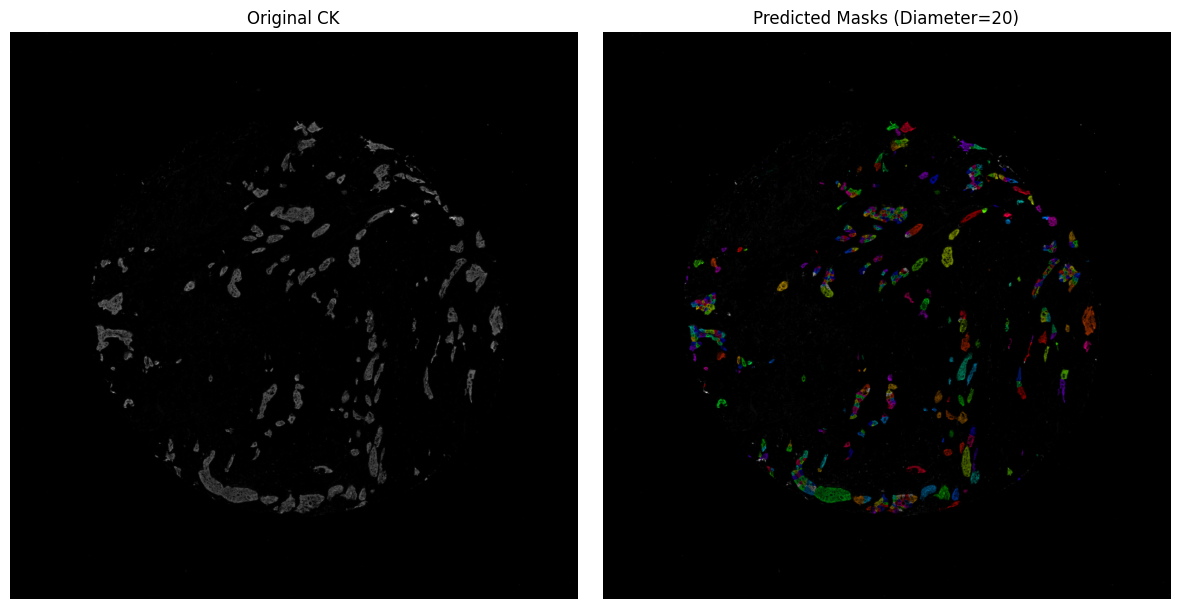

In [15]:
from cellpose import plot

fig = plt.figure(figsize=(12, 6))

# Plot Original
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(ck_vis, cmap='gray')
ax1.set_title("Original CK")
ax1.axis('off')

# Plot Masks
# Cellpose has a helper to create random colors for masks
mask_overlay = plot.mask_overlay(ck_vis, masks)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask_overlay)
ax2.set_title(f"Predicted Masks (Diameter={DIAMETER})")
ax2.axis('off')

plt.tight_layout()
plt.show()

Filtering 627 regions down to top 6...
Selected 6 spatially distributed landmarks.


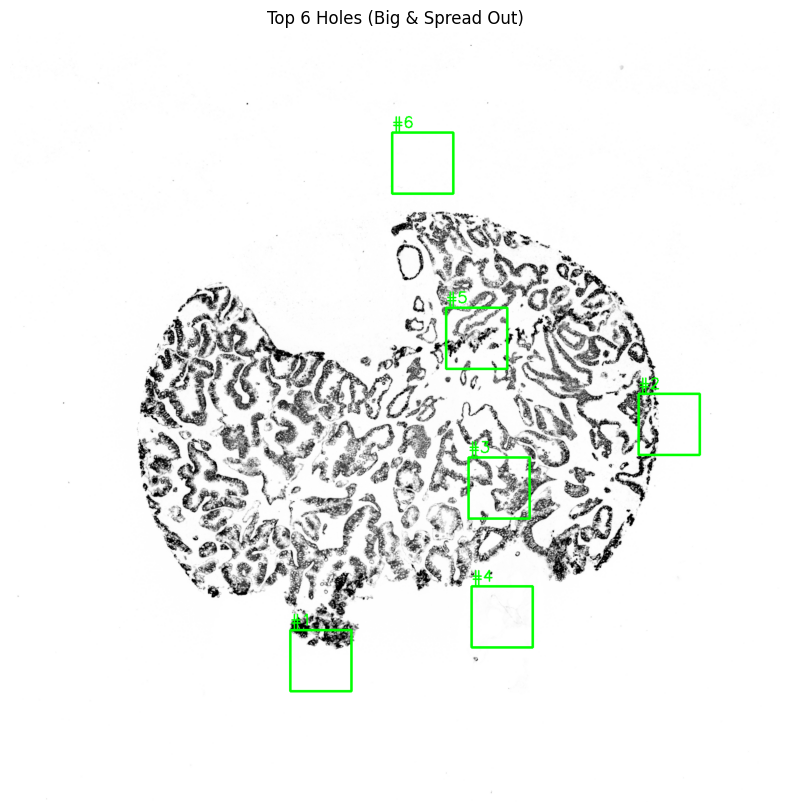

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# --- CONFIGURATION ---
TARGET_LANDMARKS = 6    
MIN_DIST_PX = 150       
BOX_SIZE = 120          
MIN_AREA = 100          

# --- SAFETY CHECK: Re-create img_norm if missing ---
# This ensures the cell works even if you restarted the kernel
if 'img_norm' not in locals():
    print("Warning: img_norm not found. Re-calculating from 'ck'...")
    # Assuming 'ck' is your loaded raw image. If 'ck' is also missing, 
    # you need to re-run the "Load Image" cell at the top.
    raw_img = ck.copy()
    p1, p99 = np.percentile(raw_img[raw_img > 0], (1, 99))
    img_norm = np.clip((raw_img - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
    img_norm = img_norm.astype(np.uint8)
    
    # Re-create inverted image for visualization
    img_inverted = 255 - img_norm

def select_best_landmarks(masks, target_count, min_dist):
    # 1. Get properties of all regions
    props = regionprops(masks)
    
    # 2. Filter out tiny regions and sort by AREA (Largest = Most Stable)
    valid_regions = [p for p in props if p.area > MIN_AREA]
    valid_regions.sort(key=lambda x: x.area, reverse=True)
    
    selected_anchors = []
    
    # 3. Iterative Selection (Spatial Exclusion)
    for region in valid_regions:
        if len(selected_anchors) >= target_count:
            break
            
        y, x = region.centroid
        
        # Check distance to all currently selected anchors
        too_close = False
        for anchor in selected_anchors:
            ay, ax = anchor['centroid']
            dist = np.sqrt((x - ax)**2 + (y - ay)**2)
            if dist < min_dist:
                too_close = True
                break
        
        if not too_close:
            y_min = int(y - BOX_SIZE // 2)
            x_min = int(x - BOX_SIZE // 2)
            
            selected_anchors.append({
                'centroid': (y, x),
                'bbox': [x_min, y_min, BOX_SIZE, BOX_SIZE], 
                'area': region.area,
                'label': region.label
            })
            
    return selected_anchors

# --- EXECUTE SELECTION ---
print(f"Filtering {len(np.unique(masks))-1} regions down to top {TARGET_LANDMARKS}...")
anchors = select_best_landmarks(masks, TARGET_LANDMARKS, MIN_DIST_PX)

print(f"Selected {len(anchors)} spatially distributed landmarks.")

# --- VISUALIZATION ---
# Use inverted image so the holes look like white objects
vis_img = cv2.cvtColor(img_inverted, cv2.COLOR_GRAY2RGB)

for i, anchor in enumerate(anchors):
    x, y, w, h = anchor['bbox']
    
    # Draw Green Box
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    
    # Label
    cv2.putText(vis_img, f"#{i+1}", (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.title(f"Top {len(anchors)} Holes (Big & Spread Out)")
plt.axis('off')
plt.show()

model_type argument is not used in v4.0.1+. Ignoring this argument...


Running Cellpose on Masked Inverted Image...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


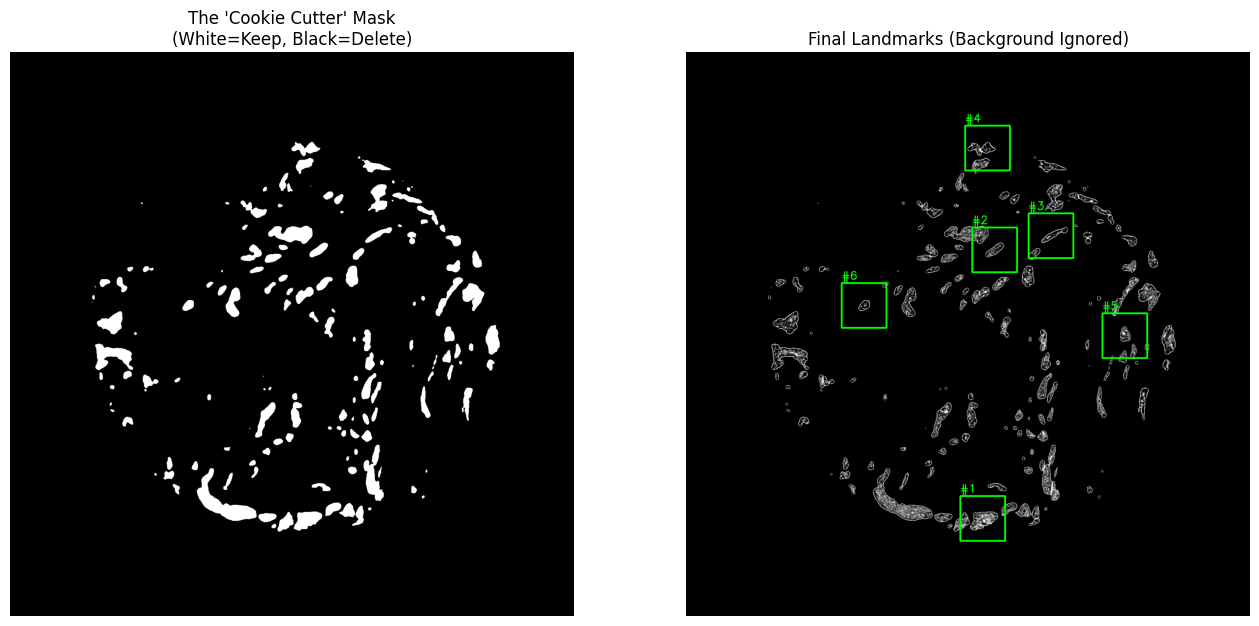

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, plot
from scipy.ndimage import binary_fill_holes
from skimage.measure import regionprops

# --- CONFIGURATION ---
MODEL_TYPE = 'nuclei'
DIAMETER = 30
FLOW_THRESHOLD = 0.9
CELLPROB_THRESHOLD = -1.0
MIN_SIZE = 50
TARGET_LANDMARKS = 6
MIN_DIST_PX = 150
BOX_SIZE = 120

# 1. Load & Normalize
# Re-create img_norm from 'ck' to be safe
if 'ck' not in locals(): print("Error: Please load 'ck' image first.")
raw_img = ck.copy()
p1, p99 = np.percentile(raw_img[raw_img > 0], (1, 99))
img_norm = np.clip((raw_img - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
img_norm = img_norm.astype(np.uint8)

# 2. GENERATE THE "COOKIE CUTTER" MASK (The Fix)
# Goal: Find the 'Disk' of the core to exclude the background.
# A. Threshold to find tissue
blur = cv2.GaussianBlur(img_norm, (15, 15), 0)
_, tissue_binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# B. Fill Holes (This turns the O-shape into a solid D-shape)
# This captures the internal holes but leaves the external background 0.
core_mask = binary_fill_holes(tissue_binary).astype(np.uint8)

# 3. PREPARE INPUT
# Invert the image (Holes become white)
img_inverted = 255 - img_norm

# APPLY THE MASK (Force Background to Black)
img_final_input = img_inverted * core_mask

# 4. RUN INFERENCE
print("Running Cellpose on Masked Inverted Image...")
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

masks, _, _ = model.eval(
    img_final_input, 
    diameter=DIAMETER, 
    channels=[0,0],
    flow_threshold=FLOW_THRESHOLD,
    cellprob_threshold=CELLPROB_THRESHOLD,
    min_size=MIN_SIZE
)

# 5. SELECT LANDMARKS
props = regionprops(masks)
valid_regions = [p for p in props if p.area > 100]
valid_regions.sort(key=lambda x: x.area, reverse=True)

selected_anchors = []
for region in valid_regions:
    if len(selected_anchors) >= TARGET_LANDMARKS: break
    y, x = region.centroid
    
    too_close = False
    for anchor in selected_anchors:
        ay, ax = anchor['centroid']
        if np.sqrt((x - ax)**2 + (y - ay)**2) < MIN_DIST_PX:
            too_close = True; break
    
    if not too_close:
        x_min = int(x - BOX_SIZE//2)
        y_min = int(y - BOX_SIZE//2)
        selected_anchors.append({'centroid': (y, x), 'bbox': [x_min, y_min, BOX_SIZE, BOX_SIZE]})

# 6. VISUALIZATION
# We show the "Final Input" to prove the background is black
vis_img = cv2.cvtColor(img_final_input, cv2.COLOR_GRAY2RGB)

for i, anchor in enumerate(selected_anchors):
    x, y, w, h = anchor['bbox']
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    cv2.putText(vis_img, f"#{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(core_mask, cmap='gray')
ax[0].set_title("The 'Cookie Cutter' Mask\n(White=Keep, Black=Delete)")
ax[0].axis('off')

ax[1].imshow(vis_img)
ax[1].set_title(f"Final Landmarks (Background Ignored)")
ax[1].axis('off')

plt.show()

In [18]:
import os
import sys
import cv2
import numpy as np
import tifffile
import json
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from cellpose import models
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes

# --- CONFIGURATION ---
# Adjust paths as needed

import config
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")
OUTPUT_JSON = os.path.join(config.DATASPACE, "initial_regions.json")
QC_DIR = os.path.join(config.DATASPACE, "Cellpose_Landmarks_QC")


os.makedirs(QC_DIR, exist_ok=True)

# MODEL PARAMETERS (Tuned for "Spiderweb Holes")
MODEL_TYPE = 'nuclei'
DIAMETER = 30
FLOW_THRESHOLD = 0.9
CELLPROB_THRESHOLD = -1.0
MIN_SIZE = 50
CK_INDEX = 6

# LANDMARK SELECTION
TARGET_LANDMARKS = 6
MIN_DIST_PX = 150
BOX_SIZE = 120

# Initialize Model (Load once)
print(f"Initializing Cellpose ({MODEL_TYPE})...")
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

def get_cookie_cutter_mask(img):
    """
    Creates a solid mask of the tissue core to hide the background.
    """
    # 1. Blur to merge web strands
    blur = cv2.GaussianBlur(img, (21, 21), 0)
    
    # 2. Threshold
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Fill Holes (The "Cookie Cutter" Step)
    # This ensures the internal holes we want to track are kept inside the mask,
    # but the external background is excluded.
    mask = binary_fill_holes(binary).astype(np.uint8)
    return mask

def process_core(core_folder, core_id):
    # 1. Find Anchor Slice (Middle)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None
    
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 2. Load Image
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # 3. Robust Normalization
        raw_img = ck.copy()
        if raw_img.max() == 0: return None
        p1, p99 = np.percentile(raw_img[raw_img > 0], (1, 99))
        img_norm = np.clip((raw_img - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
        img_norm = img_norm.astype(np.uint8)
        
        # 4. PREPARE INPUT (Invert + Mask)
        # A. Invert (Holes -> White)
        img_inverted = 255 - img_norm
        
        # B. Generate Cookie Cutter Mask (White Disk)
        core_mask = get_cookie_cutter_mask(img_norm)
        
        # C. Apply Mask (Background -> Black)
        img_final_input = img_inverted * core_mask
        
        # 5. RUN CELLPOSE
        masks, _, _ = model.eval(
            img_final_input, 
            diameter=DIAMETER, 
            channels=[0,0],
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
            min_size=MIN_SIZE
        )
        
        # 6. SELECT LANDMARKS
        props = regionprops(masks)
        valid_regions = [p for p in props if p.area > 100]
        valid_regions.sort(key=lambda x: x.area, reverse=True) # Largest holes first
        
        selected_boxes = []
        selected_centers = []
        
        for region in valid_regions:
            if len(selected_boxes) >= TARGET_LANDMARKS: break
            
            y, x = region.centroid
            
            # Distance Check
            too_close = False
            for (cy, cx) in selected_centers:
                if np.sqrt((x - cx)**2 + (y - cy)**2) < MIN_DIST_PX:
                    too_close = True; break
            
            if not too_close:
                # Save as [x, y, w, h] (Top-Left corner)
                x_min = int(max(0, x - BOX_SIZE//2))
                y_min = int(max(0, y - BOX_SIZE//2))
                
                selected_boxes.append([x_min, y_min, BOX_SIZE, BOX_SIZE])
                selected_centers.append((y, x))
        
        # 7. GENERATE QC IMAGE
        if selected_boxes:
            # Visualize on the INVERTED image so boxes match the "white blobs"
            vis_img = cv2.cvtColor(img_final_input, cv2.COLOR_GRAY2RGB)
            
            for i, box in enumerate(selected_boxes):
                bx, by, bw, bh = box
                cv2.rectangle(vis_img, (bx, by), (bx+bw, by+bh), (0, 255, 0), 4)
                cv2.putText(vis_img, f"#{i+1}", (bx, by-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
            
            qc_path = os.path.join(QC_DIR, f"{core_id}_Landmarks.jpg")
            cv2.imwrite(qc_path, vis_img)
            
        return {
            "Anchor_Index": mid_idx,
            "Regions": selected_boxes
        }

    except Exception as e:
        print(f"Failed {core_id}: {e}")
        return None

# --- MAIN EXECUTION ---
print("="*60)
print(f"  BATCH CELLPOSE DISCOVERY (Inverted + Masked)")
print("="*60)

core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))
database = {}

for folder in tqdm(core_folders):
    core_id = os.path.basename(folder)
    result = process_core(folder, core_id)
    if result and result["Regions"]:
        database[core_id] = result

# Save JSON
with open(OUTPUT_JSON, 'w') as f:
    json.dump(database, f, indent=4)

print(f"\nSUCCESS. Processed {len(database)} cores.")
print(f"Landmark data saved to: {OUTPUT_JSON}")
print(f"QC Images saved to: {QC_DIR}")

model_type argument is not used in v4.0.1+. Ignoring this argument...


Initializing Cellpose (nuclei)...
  BATCH CELLPOSE DISCOVERY (Inverted + Masked)


100%|██████████| 30/30 [01:39<00:00,  3.31s/it]


SUCCESS. Processed 29 cores.
Landmark data saved to: /data3/junming/3D-TMA-Register/initial_regions.json
QC Images saved to: /data3/junming/3D-TMA-Register/Cellpose_Landmarks_QC


In [19]:
import os
import sys
import cv2
import numpy as np
import tifffile
import json
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from cellpose import models
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes


import config
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")
OUTPUT_JSON = os.path.join(config.DATASPACE, "initial_regions.json")
QC_DIR = os.path.join(config.DATASPACE, "Cellpose_Landmarks_QC")


os.makedirs(QC_DIR, exist_ok=True)

# MODEL PARAMETERS
MODEL_TYPE = 'nuclei'
DIAMETER = 30
FLOW_THRESHOLD = 0.9
CELLPROB_THRESHOLD = -1.0
MIN_SIZE = 50
CK_INDEX = 6

# LANDMARK SELECTION
TARGET_LANDMARKS = 6
MIN_DIST_PX = 150
PADDING = 10  # Add 10px padding around the tight mask

print(f"Initializing Cellpose ({MODEL_TYPE})...")
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

def get_cookie_cutter_mask(img):
    blur = cv2.GaussianBlur(img, (21, 21), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = binary_fill_holes(binary).astype(np.uint8)
    return mask

def process_core(core_folder, core_id):
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None
    
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 1. Load & Normalize
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        raw_img = ck.copy()
        if raw_img.max() == 0: return None
        p1, p99 = np.percentile(raw_img[raw_img > 0], (1, 99))
        img_norm = np.clip((raw_img - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
        img_norm = img_norm.astype(np.uint8)
        
        # 2. PREPARE INPUT (Invert + Cookie Cutter)
        img_inverted = 255 - img_norm
        core_mask = get_cookie_cutter_mask(img_norm)
        img_final_input = img_inverted * core_mask
        
        # 3. RUN CELLPOSE
        masks, _, _ = model.eval(
            img_final_input, 
            diameter=DIAMETER, 
            channels=[0,0],
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
            min_size=MIN_SIZE
        )
        
        # 4. SELECT LANDMARKS (Dynamic Sizing)
        props = regionprops(masks)
        valid_regions = [p for p in props if p.area > 100]
        valid_regions.sort(key=lambda x: x.area, reverse=True)
        
        selected_data = []
        selected_centers = []
        
        for region in valid_regions:
            if len(selected_data) >= TARGET_LANDMARKS: break
            
            y, x = region.centroid
            
            # Spatial Exclusion
            too_close = False
            for (cy, cx) in selected_centers:
                if np.sqrt((x - cx)**2 + (y - cy)**2) < MIN_DIST_PX:
                    too_close = True; break
            
            if not too_close:
                # DYNAMIC BOX CALCULATION
                min_row, min_col, max_row, max_col = region.bbox
                
                # Add Padding (but keep inside image)
                h, w = img_norm.shape
                y1 = max(0, min_row - PADDING)
                x1 = max(0, min_col - PADDING)
                y2 = min(h, max_row + PADDING)
                x2 = min(w, max_col + PADDING)
                
                # Calculate width/height
                box_w = x2 - x1
                box_h = y2 - y1
                
                selected_data.append({
                    "box": [int(x1), int(y1), int(box_w), int(box_h)],
                    "label": region.label,
                    "centroid": (int(x), int(y))
                })
                selected_centers.append((y, x))
        
        # 5. GENERATE QC IMAGE (Black Background Style)
        if selected_data:
            # We visualize on 'img_final_input' so background is BLACK and holes are WHITE
            vis_img = cv2.cvtColor(img_final_input, cv2.COLOR_GRAY2RGB)
            
            for i, item in enumerate(selected_data):
                bx, by, bw, bh = item['box']
                label = item['label']
                
                # Draw TIGHT Green Box
                cv2.rectangle(vis_img, (bx, by), (bx+bw, by+bh), (0, 255, 0), 2)
                
                # Draw CYAN CONTOUR (The exact shape Cellpose found)
                # We extract the contour from the mask
                mask_roi = (masks == label).astype(np.uint8)
                contours, _ = cv2.findContours(mask_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(vis_img, contours, -1, (0, 255, 255), 1) # Cyan, thin line
                
                # Label
                cv2.putText(vis_img, f"#{i+1}", (bx, by-5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            qc_path = os.path.join(QC_DIR, f"{core_id}_Landmarks.jpg")
            cv2.imwrite(qc_path, vis_img)
            
            # Prepare JSON output (just the boxes)
            json_boxes = [item['box'] for item in selected_data]
            return {
                "Anchor_Index": mid_idx,
                "Regions": json_boxes
            }

    except Exception as e:
        print(f"Failed {core_id}: {e}")
        return None

# --- MAIN EXECUTION ---
print("="*60)
print(f"  BATCH DISCOVERY: Tight-Fit Boxes & Contours")
print("="*60)

core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))
database = {}

for folder in tqdm(core_folders):
    core_id = os.path.basename(folder)
    result = process_core(folder, core_id)
    if result and result["Regions"]:
        database[core_id] = result

# Save JSON
with open(OUTPUT_JSON, 'w') as f:
    json.dump(database, f, indent=4)

print(f"\nSUCCESS. Processed {len(database)} cores.")
print(f"Check QC Folder: {QC_DIR}")

model_type argument is not used in v4.0.1+. Ignoring this argument...


Initializing Cellpose (nuclei)...
  BATCH DISCOVERY: Tight-Fit Boxes & Contours


100%|██████████| 30/30 [01:38<00:00,  3.30s/it]


SUCCESS. Processed 29 cores.
Check QC Folder: /data3/junming/3D-TMA-Register/Cellpose_Landmarks_QC


### 4. Filter for "Stable" Regions

Stable Regions Found:
  Region 1: Area=498 px, Centroid=(946, 578)
  Region 2: Area=552 px, Centroid=(964, 693)
  Region 3: Area=906 px, Centroid=(1167, 805)
  Region 4: Area=725 px, Centroid=(499, 806)
  Region 5: Area=492 px, Centroid=(1119, 806)
  Region 6: Area=1132 px, Centroid=(555, 847)
  Region 7: Area=815 px, Centroid=(1185, 879)
  Region 8: Area=530 px, Centroid=(1062, 896)
  Region 9: Area=1375 px, Centroid=(767, 931)
  Region 10: Area=1010 px, Centroid=(730, 938)
  Region 11: Area=1492 px, Centroid=(793, 944)


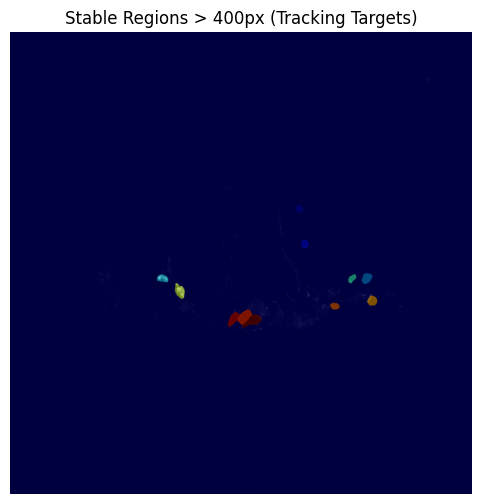

In [24]:
# Show only large regions (Area > 400 pixels) which we would actually track.

# %%
MIN_AREA = 400

# Filter masks
u_ids = np.unique(masks)
filtered_mask = np.zeros_like(masks)
count = 0

print("Stable Regions Found:")
for uid in u_ids:
    if uid == 0: continue
    
    binary = (masks == uid)
    area = np.sum(binary)
    
    if area > MIN_AREA:
        count += 1
        filtered_mask[binary] = uid
        # Calculate centroid for display
        y, x = np.where(binary)
        cy, cx = int(np.mean(y)), int(np.mean(x))
        print(f"  Region {count}: Area={area} px, Centroid=({cx}, {cy})")

# Visualize Filtered
fig = plt.figure(figsize=(6, 6))
plt.imshow(ck_vis, cmap='gray')
plt.imshow(filtered_mask, cmap='jet', alpha=0.5) # Overlay with transparency
plt.title(f"Stable Regions > {MIN_AREA}px (Tracking Targets)")
plt.axis('off')
plt.show()

### 5. Batch Run on ALL Cores (QC Generation)

In [25]:
import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from cellpose import plot

# --- CONFIGURATION ---
OUTPUT_QC_DIR = os.path.join(INPUT_ROOT, "Cellpose_QC_30diameter")
os.makedirs(OUTPUT_QC_DIR, exist_ok=True)

# Parameters (Ensure these match what you tuned above)
BATCH_DIAMETER = 60
BATCH_FLOW_THRESH = 0.4
CK_INDEX = 6 

print(f"Starting Batch QC Run...")
print(f"Results will be saved to: {OUTPUT_QC_DIR}")

# Find all core folders
core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))

for core_folder in tqdm(core_folders):
    core_id = os.path.basename(core_folder)
    
    # 1. Find Middle Slice
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: continue
    
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 2. Load Image
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # Normalize for Cellpose (0-1 range is often better, but it handles raw too)
        # We'll normalize for visualization consistency
        ck_vis = cv2.normalize(ck, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # 3. Run Inference
        # Note: We use the 'model' object you initialized in the previous cells
        masks, flows, styles = model.eval(
            ck, 
            diameter=BATCH_DIAMETER, 
            channels=[0,0], 
            flow_threshold=BATCH_FLOW_THRESH
        )
        
        # 4. Create Visualization
        # Create a figure with 2 subplots
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Left: Raw Image
        ax[0].imshow(ck_vis, cmap='gray')
        ax[0].set_title(f"{core_id} - Slice {mid_idx}\nRaw CK")
        ax[0].axis('off')
        
        # Right: Mask Overlay
        mask_overlay = plot.mask_overlay(ck_vis, masks)
        ax[1].imshow(mask_overlay)
        ax[1].set_title(f"Cellpose Prediction\n(Diam={BATCH_DIAMETER})")
        ax[1].axis('off')
        
        # 5. Save to Disk
        save_path = os.path.join(OUTPUT_QC_DIR, f"{core_id}_QC.jpg")
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close(fig) # Close to free memory
        
    except Exception as e:
        print(f"Failed {core_id}: {e}")

print("Batch Run Complete. Check the 'Cellpose_QC' folder.")

Starting Batch QC Run...
Results will be saved to: /data3/junming/3D-TMA-Register/downsampled_4x/Cellpose_QC_30diameter


100%|██████████| 30/30 [05:28<00:00, 10.97s/it]

Batch Run Complete. Check the 'Cellpose_QC' folder.
